In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/xview_recognition.zip"

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3500)]
    )
    # tf.config.experimental.set_memory_growth(gpus[0], True)

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

2024-04-16 15:25:25.002057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 15:25:25.038968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 15:25:25.039004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 15:25:25.039998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 15:25:25.046507: I tensorflow/core/platform/cpu_feature_guar

1 Physical GPU, 1 Logical GPUs


2024-04-16 15:25:27.404255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 15:25:27.435251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 15:25:27.435314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 15:25:27.438376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 15:25:27.438420: I external/local_xla/xla/stream_executor

In [4]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

    def get_object_categories(self):
        categories = []
        for obj in self.objects:
            categories.append(obj.category)
        return categories

In [5]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [6]:
# !pip install rasterio

In [7]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import rasterio
from rasterio.errors import RasterioIOError

def load_geoimage(filename):
    try:
        with rasterio.open(filename, 'r') as src_raster:
            # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
            input_type = src_raster.profile['dtype']
            input_channels = src_raster.count
            img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
            for band in range(input_channels):
                img[:, :, band] = src_raster.read(band+1)
        return img
    except RasterioIOError as e:
        print(f"Error loading image '{filename}': {e}")
        return None




In [8]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [9]:
def generator_images(objs, batch_size, minority_categories=None, data_augmentation=False, do_shuffle=False):
    if data_augmentation and minority_categories is None:
        raise ValueError("If data_augmentation is True, minority_categories must be provided.")

    if data_augmentation:
        # Define data augmentation parameters
        data_gen = ImageDataGenerator(
             rotation_range=30,
             width_shift_range=0.1,
             height_shift_range=0.1,
             horizontal_flip=True,
             shear_range=0.2,
             zoom_range=0.1,
             brightness_range=[0.5, 1.5],
             fill_mode='nearest',
             cval=0.0,
             vertical_flip=True,
             rescale=1./255,
             data_format='channels_last',
             validation_split=0.2,
             interpolation_order=2,
        )

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Check if data augmentation is enabled and minority categories are provided
                if data_augmentation and minority_categories is not None and obj.category in minority_categories:
                    img = data_gen.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            if images:
                images = np.array(images).astype(np.float32)
                labels = np.array(labels).astype(np.float32)
                yield images, labels
            else:
                # If there are no more images, break the loop
                break


In [10]:
import json
# Load database
#json_file = '/content/drive/MyDrive/Colab Notebooks/xview_ann_train.json'
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [11]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [12]:
from sklearn.model_selection import train_test_split
import random

random.seed(123)

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

## Count how many obj for categories in training

## Data augmentation to balance classes

In [13]:
minority_classes = ["Helicopter", "Bus", "Fishing vessel", "Dump truck", "Shipping container"]

In [14]:
minority_samples = [image for image in anns_train if any(obj.category in minority_classes for obj in image.objects)]

In [15]:
# Load architecture
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model


def create_model(n_neurons):
    print('Load model')
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional base
    base_model.trainable = False

    # Create a new model on top of the pre-trained base
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    outputs = Dense(n_neurons, activation='softmax')(x)

    # Compile the model
    model = Model(inputs, outputs)


    # Print model summary
    model.summary()

    opt = Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
import math
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
# Create the training generator with augmentation only for minority categories
train_generator = generator_images(objs_train, batch_size, minority_classes, data_augmentation=True, do_shuffle=True)
# Create the validation generator without augmentation
validation_generator = generator_images(objs_valid, batch_size, data_augmentation=False, do_shuffle=False)

epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

In [17]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [18]:
model = create_model(12)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=validation_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Load model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                  

/home/luckydan/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/20


2024-04-16 15:25:41.031071: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:25:41.413416: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-16 15:25:41.554734: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:25:43.702051: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb05d5be350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 15:25:43.702098: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-16 15:25:43.712155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713273943.851015  720703 devic

301/301 [==============================] - ETA: 0s - loss: 2.6661 - accuracy: 0.4912
Epoch 1: val_accuracy improved from -inf to 0.59448, saving model to model.hdf5


/home/luckydan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


301/301 [==============================] - 166s 518ms/step - loss: 2.6661 - accuracy: 0.4912 - val_loss: 2.3391 - val_accuracy: 0.5945 - lr: 1.0000e-04
Epoch 2/20
301/301 [==============================] - ETA: 0s - loss: 2.0674 - accuracy: 0.6574
Epoch 2: val_accuracy improved from 0.59448 to 0.62348, saving model to model.hdf5
301/301 [==============================] - 129s 431ms/step - loss: 2.0674 - accuracy: 0.6574 - val_loss: 2.2145 - val_accuracy: 0.6235 - lr: 1.0000e-04
Epoch 3/20
301/301 [==============================] - ETA: 0s - loss: 1.9010 - accuracy: 0.6993
Epoch 3: val_accuracy improved from 0.62348 to 0.63517, saving model to model.hdf5
301/301 [==============================] - 127s 423ms/step - loss: 1.9010 - accuracy: 0.6993 - val_loss: 2.1525 - val_accuracy: 0.6352 - lr: 1.0000e-04
Epoch 4/20
301/301 [==============================] - ETA: 0s - loss: 1.7873 - accuracy: 0.7223
Epoch 4: val_accuracy improved from 0.63517 to 0.64780, saving model to model.hdf5
301/301

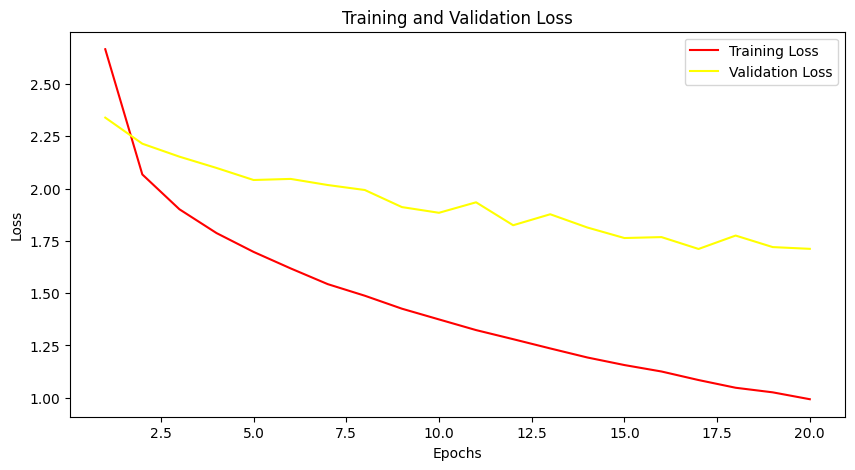

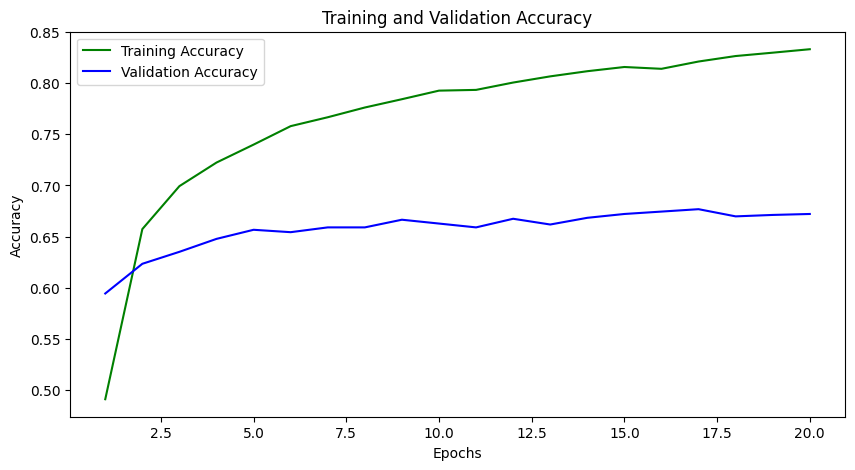

In [19]:
# Plotting
epochs_range = range(1, epochs+1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss', color='red')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [20]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [21]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [22]:
import numpy as np

# model.load_weights('model.keras')
y_true, y_pred = [], []
for index, ann in enumerate(anns):
    print(index)
    # Load image
    image = load_geoimage(ann.filename)
    for index, obj_pred in enumerate(ann.objects):
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)


0
1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 26ms/step
2
1/1 [==============================] - 0s 50ms/step
3
1/1 [==============================] - 0s 26ms/step
4
1/1 [==============================] - 0s 25ms/step
5
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 25ms/step
7
1/1 [==============================] - 0s 25ms/step
8
1/1 [==============================] - 0s 25ms/step
9
1/1 [==============================] - 0s 25ms/step
10
1/1 [==============================] - 0s 27ms/step
11
1/1 [==============================] - 0s 26ms/step
12
1/1 [==============================] - 0s 27ms/step
13
1/1 [==============================] - 0s 26ms/step
14
1/1 [==============================] - 0s 50ms/step
15
1/1 [==============================] - 0s 26ms/step
16
1/1 [==============================] - 0s 26ms/step
17
1/1 [==============================] - 0s 25ms/step
18
1/1 [==============

/tmp/ipykernel_720630/956665539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


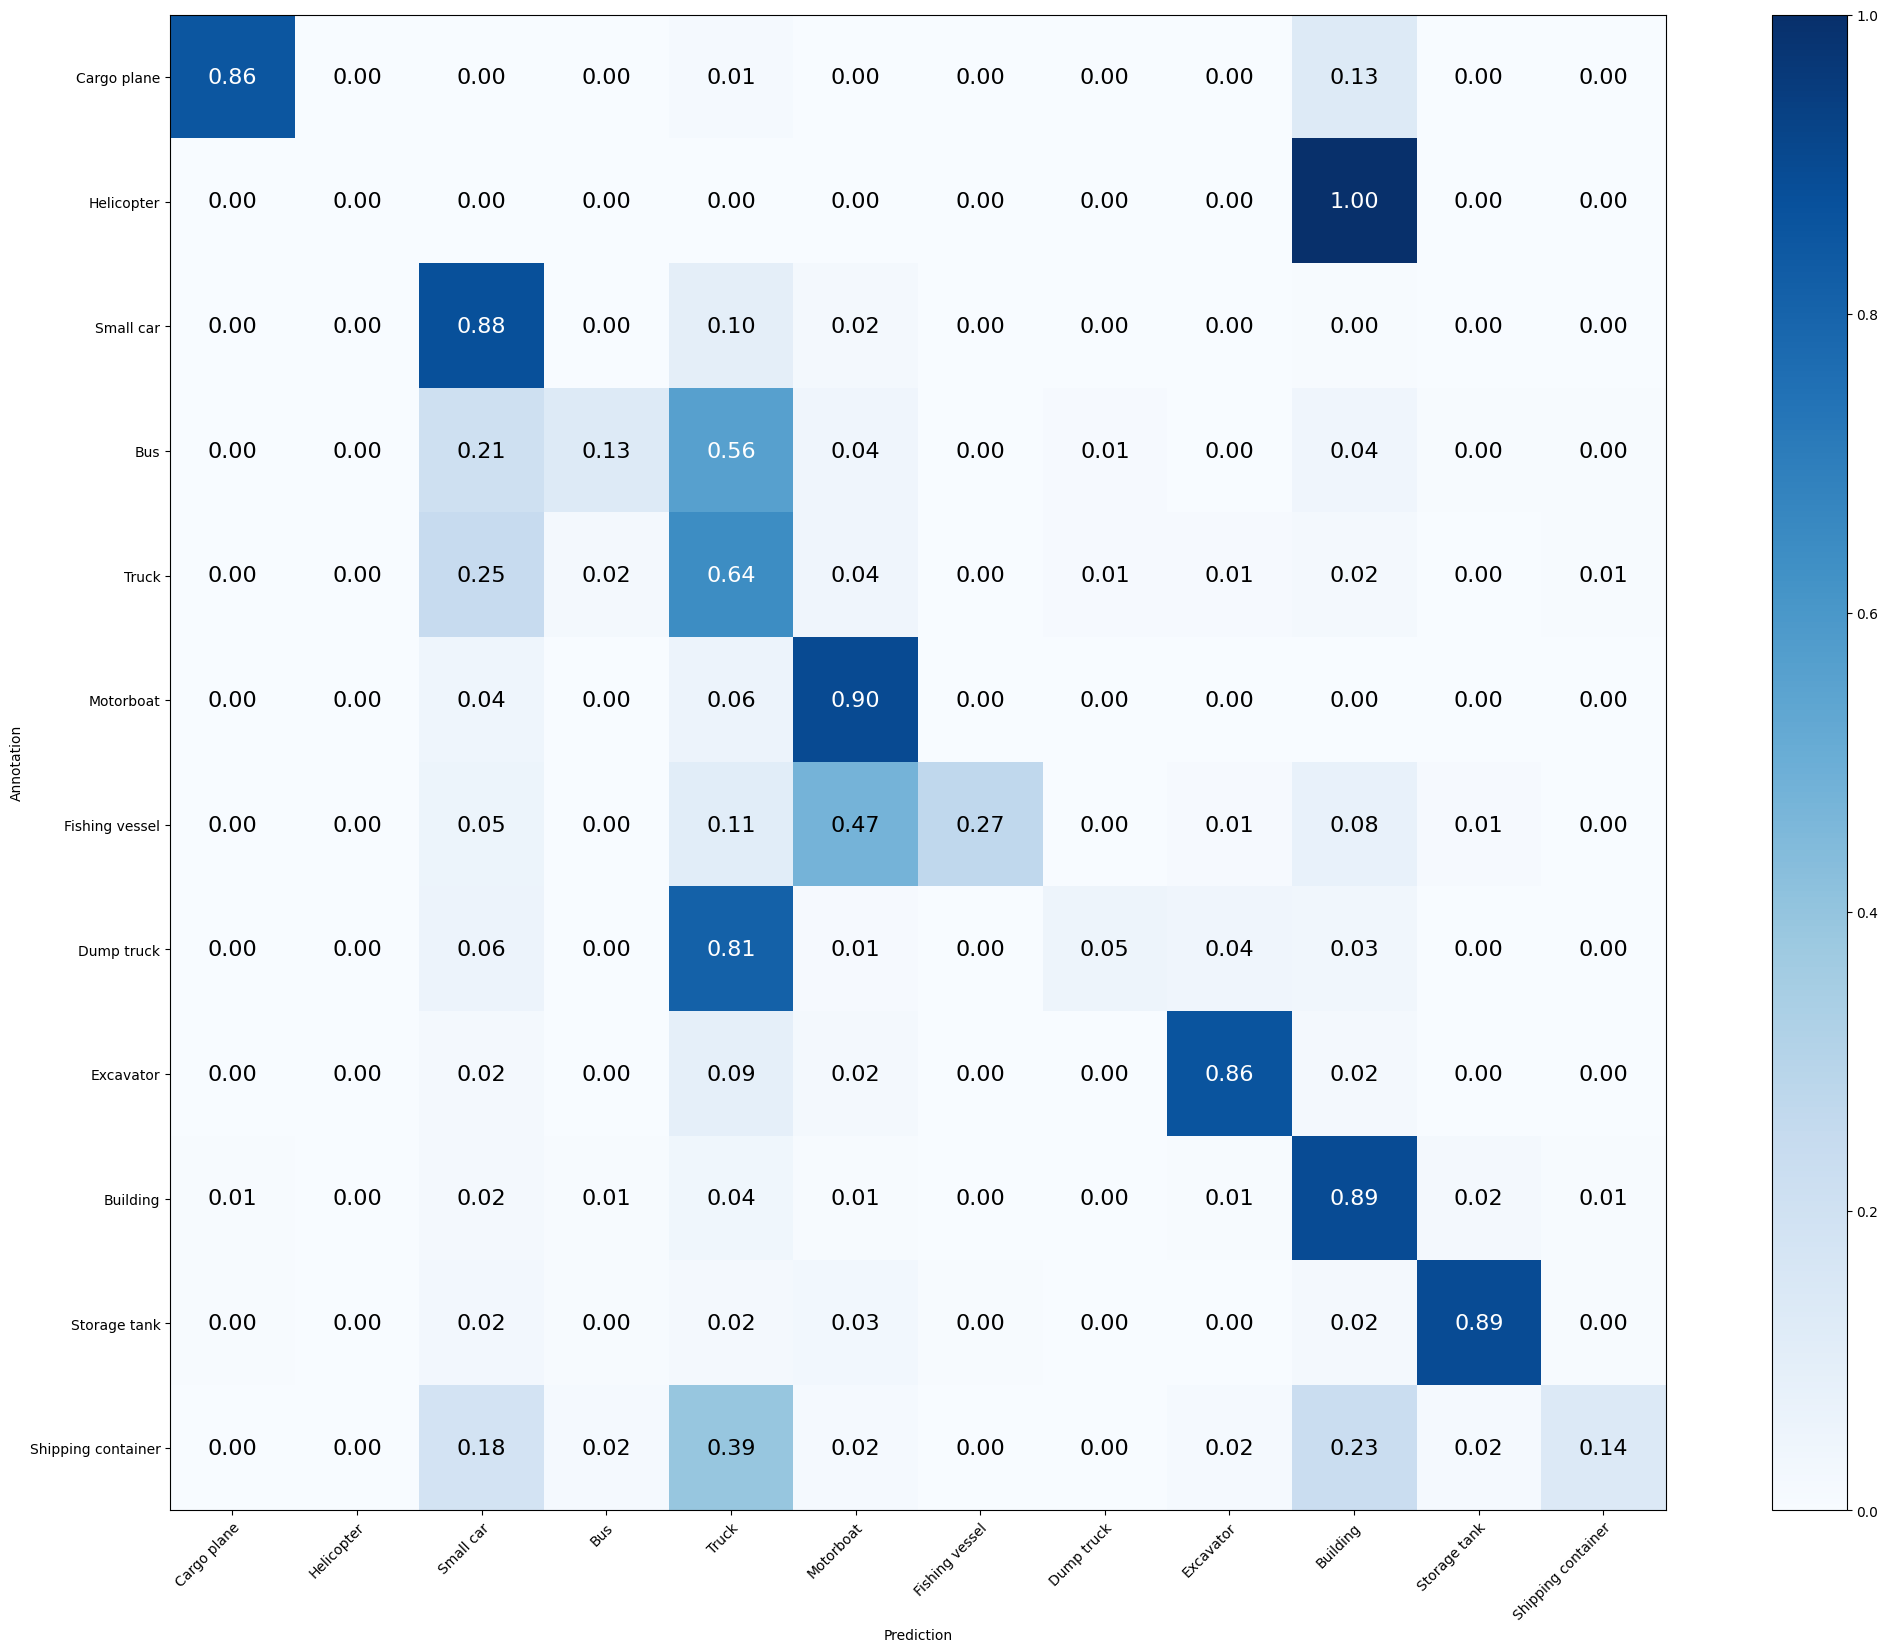

In [23]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [24]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 70.892%
Mean Recall: 54.157%
Mean Precision: 67.364%
> Cargo plane: Recall: 85.542% Precision: 94.667% Specificity: 99.843% Dice: 89.873%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 87.680% Precision: 69.885% Specificity: 91.434% Dice: 77.778%
> Bus: Recall: 12.810% Precision: 72.093% Specificity: 99.499% Dice: 21.754%
> Truck: Recall: 64.262% Precision: 34.507% Specificity: 84.034% Dice: 44.903%
> Motorboat: Recall: 89.594% Precision: 79.684% Specificity: 95.984% Dice: 84.349%
> Fishing vessel: Recall: 26.882% Precision: 86.207% Specificity: 99.843% Dice: 40.984%
> Dump truck: Recall: 4.918% Precision: 54.545% Specificity: 99.801% Dice: 9.023%
> Excavator: Recall: 85.965% Precision: 77.778% Specificity: 99.457% Dice: 81.667%
> Building: Recall: 89.299% Precision: 88.807% Specificity: 97.086% Dice: 89.052%
> Storage tank: Recall: 89.300% Precision: 93.939% Specificity: 99.415% Dice: 91.561%
> Shipping container: 